## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-06-09 04:19:15--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.3
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  75.6MB/s    in 4.4s    

2020-06-09 04:19:20 (74.1 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(100) , RandomCrop(96) , Normalize() , ToTensor()] )

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

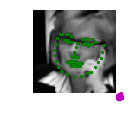

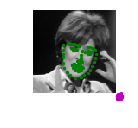

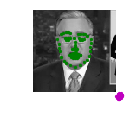

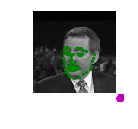

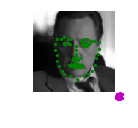

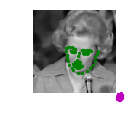

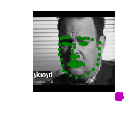

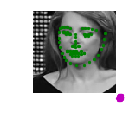

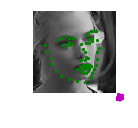

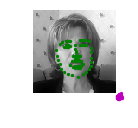

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.44683311581611634
Epoch: 1, Batch: 20, Avg. Loss: 0.16016437038779258
Epoch: 1, Batch: 30, Avg. Loss: 0.07093461379408836
Epoch: 1, Batch: 40, Avg. Loss: 0.05173973143100739
Epoch: 1, Batch: 50, Avg. Loss: 0.043415661156177524
Epoch: 1, Batch: 60, Avg. Loss: 0.03182119764387607
Epoch: 1, Batch: 70, Avg. Loss: 0.030404202826321124
Epoch: 1, Batch: 80, Avg. Loss: 0.03784188702702522
Epoch: 1, Batch: 90, Avg. Loss: 0.053377622924745086
Epoch: 1, Batch: 100, Avg. Loss: 0.037332921847701074
Epoch: 1, Batch: 110, Avg. Loss: 0.029637846909463406
Epoch: 1, Batch: 120, Avg. Loss: 0.026288322918117047
Epoch: 1, Batch: 130, Avg. Loss: 0.027212542481720448
Epoch: 1, Batch: 140, Avg. Loss: 0.0259573545306921
Epoch: 1, Batch: 150, Avg. Loss: 0.025331097096204756
Epoch: 1, Batch: 160, Avg. Loss: 0.0239195441827178
Epoch: 1, Batch: 170, Avg. Loss: 0.02349251937121153


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.02701310832053423
Epoch: 2, Batch: 20, Avg. Loss: 0.02310009114444256
Epoch: 2, Batch: 30, Avg. Loss: 0.02437674067914486
Epoch: 2, Batch: 40, Avg. Loss: 0.027004302106797697
Epoch: 2, Batch: 50, Avg. Loss: 0.026009011827409268
Epoch: 2, Batch: 60, Avg. Loss: 0.023964686691761015
Epoch: 2, Batch: 70, Avg. Loss: 0.02010603155940771
Epoch: 2, Batch: 80, Avg. Loss: 0.02227656338363886
Epoch: 2, Batch: 90, Avg. Loss: 0.02125679301097989
Epoch: 2, Batch: 100, Avg. Loss: 0.026093346253037452
Epoch: 2, Batch: 110, Avg. Loss: 0.019079631380736827
Epoch: 2, Batch: 120, Avg. Loss: 0.019819709192961454
Epoch: 2, Batch: 130, Avg. Loss: 0.021031458955258132
Epoch: 2, Batch: 140, Avg. Loss: 0.021619869116693734
Epoch: 2, Batch: 150, Avg. Loss: 0.02133802603930235
Epoch: 2, Batch: 160, Avg. Loss: 0.01927350740879774
Epoch: 2, Batch: 170, Avg. Loss: 0.020734674576669932


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.017925940733402968
Epoch: 3, Batch: 20, Avg. Loss: 0.018702771328389645
Epoch: 3, Batch: 30, Avg. Loss: 0.01795538105070591
Epoch: 3, Batch: 40, Avg. Loss: 0.018154025450348853
Epoch: 3, Batch: 50, Avg. Loss: 0.0174050185829401
Epoch: 3, Batch: 60, Avg. Loss: 0.019761385582387447
Epoch: 3, Batch: 70, Avg. Loss: 0.021143092028796672
Epoch: 3, Batch: 80, Avg. Loss: 0.0216054679825902
Epoch: 3, Batch: 90, Avg. Loss: 0.021355475205928086
Epoch: 3, Batch: 100, Avg. Loss: 0.019329500384628773
Epoch: 3, Batch: 110, Avg. Loss: 0.02212708694860339
Epoch: 3, Batch: 120, Avg. Loss: 0.02413806291297078
Epoch: 3, Batch: 130, Avg. Loss: 0.01667805826291442
Epoch: 3, Batch: 140, Avg. Loss: 0.01599813122302294
Epoch: 3, Batch: 150, Avg. Loss: 0.015875179413706066
Epoch: 3, Batch: 160, Avg. Loss: 0.015135158319026232
Epoch: 3, Batch: 170, Avg. Loss: 0.019676112569868565


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.01588108567520976
Epoch: 4, Batch: 20, Avg. Loss: 0.016415290907025336
Epoch: 4, Batch: 30, Avg. Loss: 0.016123620327562094
Epoch: 4, Batch: 40, Avg. Loss: 0.013905575312674046
Epoch: 4, Batch: 50, Avg. Loss: 0.01711920965462923
Epoch: 4, Batch: 60, Avg. Loss: 0.013975514750927686
Epoch: 4, Batch: 70, Avg. Loss: 0.015845952741801738
Epoch: 4, Batch: 80, Avg. Loss: 0.01823090501129627
Epoch: 4, Batch: 90, Avg. Loss: 0.018108421470969915
Epoch: 4, Batch: 100, Avg. Loss: 0.017072483152151107
Epoch: 4, Batch: 110, Avg. Loss: 0.013884222926571965
Epoch: 4, Batch: 120, Avg. Loss: 0.018016915768384933
Epoch: 4, Batch: 130, Avg. Loss: 0.01472195852547884
Epoch: 4, Batch: 140, Avg. Loss: 0.014434859436005355
Epoch: 4, Batch: 150, Avg. Loss: 0.017558182869106532
Epoch: 4, Batch: 160, Avg. Loss: 0.013666449021548033
Epoch: 4, Batch: 170, Avg. Loss: 0.013370096031576396


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.014931750111281871
Epoch: 5, Batch: 20, Avg. Loss: 0.014866833947598935
Epoch: 5, Batch: 30, Avg. Loss: 0.016328831017017365
Epoch: 5, Batch: 40, Avg. Loss: 0.012798871751874686
Epoch: 5, Batch: 50, Avg. Loss: 0.013511892687529326
Epoch: 5, Batch: 60, Avg. Loss: 0.012836983893066645
Epoch: 5, Batch: 70, Avg. Loss: 0.013466752041131258
Epoch: 5, Batch: 80, Avg. Loss: 0.013319515343755483
Epoch: 5, Batch: 90, Avg. Loss: 0.017277615144848824
Epoch: 5, Batch: 100, Avg. Loss: 0.013992274552583695
Epoch: 5, Batch: 110, Avg. Loss: 0.014133639540523291
Epoch: 5, Batch: 120, Avg. Loss: 0.012726283352822065
Epoch: 5, Batch: 130, Avg. Loss: 0.014000486675649881
Epoch: 5, Batch: 140, Avg. Loss: 0.013096558395773172
Epoch: 5, Batch: 150, Avg. Loss: 0.011154351569712163
Epoch: 5, Batch: 160, Avg. Loss: 0.013748142402619123
Epoch: 5, Batch: 170, Avg. Loss: 0.014855194091796874


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.016677658632397653
Epoch: 6, Batch: 20, Avg. Loss: 0.011581481620669364
Epoch: 6, Batch: 30, Avg. Loss: 0.01428730608895421
Epoch: 6, Batch: 40, Avg. Loss: 0.012642591586336493
Epoch: 6, Batch: 50, Avg. Loss: 0.012681274116039276
Epoch: 6, Batch: 60, Avg. Loss: 0.012798202270641924
Epoch: 6, Batch: 70, Avg. Loss: 0.012193379551172256
Epoch: 6, Batch: 80, Avg. Loss: 0.015463778655976057
Epoch: 6, Batch: 90, Avg. Loss: 0.011719806864857674
Epoch: 6, Batch: 100, Avg. Loss: 0.012475080695003271
Epoch: 6, Batch: 110, Avg. Loss: 0.011078881472349167
Epoch: 6, Batch: 120, Avg. Loss: 0.010649091890081763
Epoch: 6, Batch: 130, Avg. Loss: 0.009602622967213393
Epoch: 6, Batch: 140, Avg. Loss: 0.01339347092434764
Epoch: 6, Batch: 150, Avg. Loss: 0.012127463705837727
Epoch: 6, Batch: 160, Avg. Loss: 0.01253873687237501
Epoch: 6, Batch: 170, Avg. Loss: 0.010367725184187293


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.010416278801858424
Epoch: 7, Batch: 20, Avg. Loss: 0.010717200534418225
Epoch: 7, Batch: 30, Avg. Loss: 0.011862160824239253
Epoch: 7, Batch: 40, Avg. Loss: 0.01296112136915326
Epoch: 7, Batch: 50, Avg. Loss: 0.011245844699442387
Epoch: 7, Batch: 60, Avg. Loss: 0.010314567340537905
Epoch: 7, Batch: 70, Avg. Loss: 0.010855411272495985
Epoch: 7, Batch: 80, Avg. Loss: 0.011013084929436446
Epoch: 7, Batch: 90, Avg. Loss: 0.009977988759055733
Epoch: 7, Batch: 100, Avg. Loss: 0.01196751818060875
Epoch: 7, Batch: 110, Avg. Loss: 0.011171147134155035
Epoch: 7, Batch: 120, Avg. Loss: 0.015729999728500844
Epoch: 7, Batch: 130, Avg. Loss: 0.01114655495621264
Epoch: 7, Batch: 140, Avg. Loss: 0.010592855140566826
Epoch: 7, Batch: 150, Avg. Loss: 0.008948934869840742
Epoch: 7, Batch: 160, Avg. Loss: 0.01162294582463801
Epoch: 7, Batch: 170, Avg. Loss: 0.009405948268249632


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.009433665638789534
Epoch: 8, Batch: 20, Avg. Loss: 0.00897613731212914
Epoch: 8, Batch: 30, Avg. Loss: 0.011588779650628567
Epoch: 8, Batch: 40, Avg. Loss: 0.0101908418815583
Epoch: 8, Batch: 50, Avg. Loss: 0.009292698185890912
Epoch: 8, Batch: 60, Avg. Loss: 0.010607281280681492
Epoch: 8, Batch: 70, Avg. Loss: 0.011682624137029052
Epoch: 8, Batch: 80, Avg. Loss: 0.00850851908326149
Epoch: 8, Batch: 90, Avg. Loss: 0.00915467576123774
Epoch: 8, Batch: 100, Avg. Loss: 0.009369327640160918
Epoch: 8, Batch: 110, Avg. Loss: 0.009319061087444425
Epoch: 8, Batch: 120, Avg. Loss: 0.007895262632519006
Epoch: 8, Batch: 130, Avg. Loss: 0.01030742796137929
Epoch: 8, Batch: 140, Avg. Loss: 0.011209618020802736
Epoch: 8, Batch: 150, Avg. Loss: 0.00869035036303103
Epoch: 8, Batch: 160, Avg. Loss: 0.009050586726516485
Epoch: 8, Batch: 170, Avg. Loss: 0.008455535070970655


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0097911496181041
Epoch: 9, Batch: 20, Avg. Loss: 0.00806012754328549
Epoch: 9, Batch: 30, Avg. Loss: 0.010655278153717519
Epoch: 9, Batch: 40, Avg. Loss: 0.007760203024372458
Epoch: 9, Batch: 50, Avg. Loss: 0.007263307366520167
Epoch: 9, Batch: 60, Avg. Loss: 0.009853389952331782
Epoch: 9, Batch: 70, Avg. Loss: 0.008202743018046021
Epoch: 9, Batch: 80, Avg. Loss: 0.009889370668679476
Epoch: 9, Batch: 90, Avg. Loss: 0.00884383860975504
Epoch: 9, Batch: 100, Avg. Loss: 0.010546473320573568
Epoch: 9, Batch: 110, Avg. Loss: 0.008703245129436255
Epoch: 9, Batch: 120, Avg. Loss: 0.010044925473630428
Epoch: 9, Batch: 130, Avg. Loss: 0.006882991408929229
Epoch: 9, Batch: 140, Avg. Loss: 0.009542009886354208
Epoch: 9, Batch: 150, Avg. Loss: 0.00799739472568035
Epoch: 9, Batch: 160, Avg. Loss: 0.009933803929015994
Epoch: 9, Batch: 170, Avg. Loss: 0.007784820394590497


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.008230511704459787
Epoch: 10, Batch: 20, Avg. Loss: 0.008537980215623974
Epoch: 10, Batch: 30, Avg. Loss: 0.008565880497917533
Epoch: 10, Batch: 40, Avg. Loss: 0.008903788030147552
Epoch: 10, Batch: 50, Avg. Loss: 0.008735621627420188
Epoch: 10, Batch: 60, Avg. Loss: 0.008583609899505972
Epoch: 10, Batch: 70, Avg. Loss: 0.006722405552864075
Epoch: 10, Batch: 80, Avg. Loss: 0.006723907589912414
Epoch: 10, Batch: 90, Avg. Loss: 0.008448609057813883
Epoch: 10, Batch: 100, Avg. Loss: 0.007626476930454373
Epoch: 10, Batch: 110, Avg. Loss: 0.007035447563976049
Epoch: 10, Batch: 120, Avg. Loss: 0.0071208824403584
Epoch: 10, Batch: 130, Avg. Loss: 0.012549392087385059
Epoch: 10, Batch: 140, Avg. Loss: 0.00777892479673028
Epoch: 10, Batch: 150, Avg. Loss: 0.007538729999214411
Epoch: 10, Batch: 160, Avg. Loss: 0.007523280684836209
Epoch: 10, Batch: 170, Avg. Loss: 0.009021410997956992


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.010864430340006948
Epoch: 11, Batch: 20, Avg. Loss: 0.008147695800289512
Epoch: 11, Batch: 30, Avg. Loss: 0.005963400378823281
Epoch: 11, Batch: 40, Avg. Loss: 0.006769715715199709
Epoch: 11, Batch: 50, Avg. Loss: 0.0063583694864064455
Epoch: 11, Batch: 60, Avg. Loss: 0.0064706064760684965
Epoch: 11, Batch: 70, Avg. Loss: 0.012166044628247618
Epoch: 11, Batch: 80, Avg. Loss: 0.007761756982654333
Epoch: 11, Batch: 90, Avg. Loss: 0.012524277018383146
Epoch: 11, Batch: 100, Avg. Loss: 0.006079864082857966
Epoch: 11, Batch: 110, Avg. Loss: 0.007493206718936563
Epoch: 11, Batch: 120, Avg. Loss: 0.006573350029066205
Epoch: 11, Batch: 130, Avg. Loss: 0.008151152916252614
Epoch: 11, Batch: 140, Avg. Loss: 0.011820066580548882
Epoch: 11, Batch: 150, Avg. Loss: 0.007072571059688925
Epoch: 11, Batch: 160, Avg. Loss: 0.00626893425360322
Epoch: 11, Batch: 170, Avg. Loss: 0.007824065908789635


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.007986536668613552
Epoch: 12, Batch: 20, Avg. Loss: 0.009320763498544693
Epoch: 12, Batch: 30, Avg. Loss: 0.00860273172147572
Epoch: 12, Batch: 40, Avg. Loss: 0.00717866625636816
Epoch: 12, Batch: 50, Avg. Loss: 0.008004979090765118
Epoch: 12, Batch: 60, Avg. Loss: 0.006524764001369476
Epoch: 12, Batch: 70, Avg. Loss: 0.007536861440166831
Epoch: 12, Batch: 80, Avg. Loss: 0.007153298472985625
Epoch: 12, Batch: 90, Avg. Loss: 0.006869371188804508
Epoch: 12, Batch: 100, Avg. Loss: 0.007281657867133617
Epoch: 12, Batch: 110, Avg. Loss: 0.00894051669165492
Epoch: 12, Batch: 120, Avg. Loss: 0.0058828620472922925
Epoch: 12, Batch: 130, Avg. Loss: 0.010811184719204902
Epoch: 12, Batch: 140, Avg. Loss: 0.0073439339408651
Epoch: 12, Batch: 150, Avg. Loss: 0.006756542902439833
Epoch: 12, Batch: 160, Avg. Loss: 0.007533599459566176
Epoch: 12, Batch: 170, Avg. Loss: 0.009539919160306453


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.008518717903643846
Epoch: 13, Batch: 20, Avg. Loss: 0.006204992206767202
Epoch: 13, Batch: 30, Avg. Loss: 0.007314999960362912
Epoch: 13, Batch: 40, Avg. Loss: 0.006674406910315156
Epoch: 13, Batch: 50, Avg. Loss: 0.0074016204569488766
Epoch: 13, Batch: 60, Avg. Loss: 0.00773412634152919
Epoch: 13, Batch: 70, Avg. Loss: 0.006558706285431981
Epoch: 13, Batch: 80, Avg. Loss: 0.0056333270156756045
Epoch: 13, Batch: 90, Avg. Loss: 0.006839149305596948
Epoch: 13, Batch: 100, Avg. Loss: 0.0061466529499739405
Epoch: 13, Batch: 110, Avg. Loss: 0.00719319456256926
Epoch: 13, Batch: 120, Avg. Loss: 0.006618700688704848
Epoch: 13, Batch: 130, Avg. Loss: 0.008707697689533233
Epoch: 13, Batch: 140, Avg. Loss: 0.0075537838973104956
Epoch: 13, Batch: 150, Avg. Loss: 0.005474071158096195
Epoch: 13, Batch: 160, Avg. Loss: 0.008235448691993951
Epoch: 13, Batch: 170, Avg. Loss: 0.006992738670669496


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.006552689848467708
Epoch: 14, Batch: 20, Avg. Loss: 0.009437797404825688
Epoch: 14, Batch: 30, Avg. Loss: 0.006643610307946801
Epoch: 14, Batch: 40, Avg. Loss: 0.005858702259138227
Epoch: 14, Batch: 50, Avg. Loss: 0.005713496217504143
Epoch: 14, Batch: 60, Avg. Loss: 0.006329678976908326
Epoch: 14, Batch: 70, Avg. Loss: 0.0076550181256607175
Epoch: 14, Batch: 80, Avg. Loss: 0.006586761306971311
Epoch: 14, Batch: 90, Avg. Loss: 0.006395595567300916
Epoch: 14, Batch: 100, Avg. Loss: 0.006949950382113457
Epoch: 14, Batch: 110, Avg. Loss: 0.007420281739905476
Epoch: 14, Batch: 120, Avg. Loss: 0.0057996507268399
Epoch: 14, Batch: 130, Avg. Loss: 0.005913293524645269
Epoch: 14, Batch: 140, Avg. Loss: 0.008293823944404722
Epoch: 14, Batch: 150, Avg. Loss: 0.005274471011944115
Epoch: 14, Batch: 160, Avg. Loss: 0.0053190778940916065
Epoch: 14, Batch: 170, Avg. Loss: 0.006551290582865477


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.005726612266153097
Epoch: 15, Batch: 20, Avg. Loss: 0.0060987792443484064
Epoch: 15, Batch: 30, Avg. Loss: 0.007527660159394145
Epoch: 15, Batch: 40, Avg. Loss: 0.005740875843912363
Epoch: 15, Batch: 50, Avg. Loss: 0.006444296450354159
Epoch: 15, Batch: 60, Avg. Loss: 0.005039065447635949
Epoch: 15, Batch: 70, Avg. Loss: 0.005369295086711645
Epoch: 15, Batch: 80, Avg. Loss: 0.005576824187301099
Epoch: 15, Batch: 90, Avg. Loss: 0.006681820400990546
Epoch: 15, Batch: 100, Avg. Loss: 0.004822493158280849
Epoch: 15, Batch: 110, Avg. Loss: 0.005498772975988686
Epoch: 15, Batch: 120, Avg. Loss: 0.005557421245612204
Epoch: 15, Batch: 130, Avg. Loss: 0.004761622985824943
Epoch: 15, Batch: 140, Avg. Loss: 0.005246895807795226
Epoch: 15, Batch: 150, Avg. Loss: 0.005349716008640826
Epoch: 15, Batch: 160, Avg. Loss: 0.005016597989015281
Epoch: 15, Batch: 170, Avg. Loss: 0.008868146501481534


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.00484268362633884
Epoch: 16, Batch: 20, Avg. Loss: 0.006311374297365546
Epoch: 16, Batch: 30, Avg. Loss: 0.005172361107543111
Epoch: 16, Batch: 40, Avg. Loss: 0.00512522344943136
Epoch: 16, Batch: 50, Avg. Loss: 0.00693022608757019
Epoch: 16, Batch: 60, Avg. Loss: 0.006928412010893226
Epoch: 16, Batch: 70, Avg. Loss: 0.005380815174430609
Epoch: 16, Batch: 80, Avg. Loss: 0.006139020132832229
Epoch: 16, Batch: 90, Avg. Loss: 0.0050620721653103825
Epoch: 16, Batch: 100, Avg. Loss: 0.006624573701992631
Epoch: 16, Batch: 110, Avg. Loss: 0.007494646427221596
Epoch: 16, Batch: 120, Avg. Loss: 0.006198925641365349
Epoch: 16, Batch: 130, Avg. Loss: 0.00865877429023385
Epoch: 16, Batch: 140, Avg. Loss: 0.006807244196534157
Epoch: 16, Batch: 150, Avg. Loss: 0.005718563171103597
Epoch: 16, Batch: 160, Avg. Loss: 0.005375869921408594
Epoch: 16, Batch: 170, Avg. Loss: 0.006374291330575943


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0049445565789937975
Epoch: 17, Batch: 20, Avg. Loss: 0.005479877442121505
Epoch: 17, Batch: 30, Avg. Loss: 0.010033204057253896
Epoch: 17, Batch: 40, Avg. Loss: 0.005771455261856318
Epoch: 17, Batch: 50, Avg. Loss: 0.011527350777760148
Epoch: 17, Batch: 60, Avg. Loss: 0.005451095453463495
Epoch: 17, Batch: 70, Avg. Loss: 0.0053582287859171625
Epoch: 17, Batch: 80, Avg. Loss: 0.005278334720060229
Epoch: 17, Batch: 90, Avg. Loss: 0.005221645114943385
Epoch: 17, Batch: 100, Avg. Loss: 0.005527484929189086
Epoch: 17, Batch: 110, Avg. Loss: 0.005333525501191616
Epoch: 17, Batch: 120, Avg. Loss: 0.004763630242086947
Epoch: 17, Batch: 130, Avg. Loss: 0.005597673403099179
Epoch: 17, Batch: 140, Avg. Loss: 0.004838176118209958
Epoch: 17, Batch: 150, Avg. Loss: 0.004471643175929785
Epoch: 17, Batch: 160, Avg. Loss: 0.0042542064329609275
Epoch: 17, Batch: 170, Avg. Loss: 0.0052006607176735995


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0057044099550694225
Epoch: 18, Batch: 20, Avg. Loss: 0.0054725199472159146
Epoch: 18, Batch: 30, Avg. Loss: 0.006223629554733634
Epoch: 18, Batch: 40, Avg. Loss: 0.005657344334758818
Epoch: 18, Batch: 50, Avg. Loss: 0.005727257044054568
Epoch: 18, Batch: 60, Avg. Loss: 0.005449137324467302
Epoch: 18, Batch: 70, Avg. Loss: 0.006439720210619271
Epoch: 18, Batch: 80, Avg. Loss: 0.005022260104306042
Epoch: 18, Batch: 90, Avg. Loss: 0.004477872466668487
Epoch: 18, Batch: 100, Avg. Loss: 0.00462882611900568
Epoch: 18, Batch: 110, Avg. Loss: 0.005923918192274868
Epoch: 18, Batch: 120, Avg. Loss: 0.006658191024325788
Epoch: 18, Batch: 130, Avg. Loss: 0.006425969558767975
Epoch: 18, Batch: 140, Avg. Loss: 0.0057599701220169665
Epoch: 18, Batch: 150, Avg. Loss: 0.007623985363170505
Epoch: 18, Batch: 160, Avg. Loss: 0.005485524167306721
Epoch: 18, Batch: 170, Avg. Loss: 0.004737415327690541


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.005457982118241489
Epoch: 19, Batch: 20, Avg. Loss: 0.004212675313465297
Epoch: 19, Batch: 30, Avg. Loss: 0.006676930794492364
Epoch: 19, Batch: 40, Avg. Loss: 0.005701196985319257
Epoch: 19, Batch: 50, Avg. Loss: 0.0047426559962332245
Epoch: 19, Batch: 60, Avg. Loss: 0.0044993053190410135
Epoch: 19, Batch: 70, Avg. Loss: 0.005066585238091647
Epoch: 19, Batch: 80, Avg. Loss: 0.006944140512496233
Epoch: 19, Batch: 90, Avg. Loss: 0.00595539016649127
Epoch: 19, Batch: 100, Avg. Loss: 0.004660447034984827
Epoch: 19, Batch: 110, Avg. Loss: 0.005015202309004962
Epoch: 19, Batch: 120, Avg. Loss: 0.005337908491492271
Epoch: 19, Batch: 130, Avg. Loss: 0.005520850792527199
Epoch: 19, Batch: 140, Avg. Loss: 0.005108409840613603
Epoch: 19, Batch: 150, Avg. Loss: 0.0036904026055708528
Epoch: 19, Batch: 160, Avg. Loss: 0.006663328409194947
Epoch: 19, Batch: 170, Avg. Loss: 0.005105781904421747


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.006068899156525731
Epoch: 20, Batch: 20, Avg. Loss: 0.0048293319530785086
Epoch: 20, Batch: 30, Avg. Loss: 0.004908800334669649
Epoch: 20, Batch: 40, Avg. Loss: 0.004934931034222245
Epoch: 20, Batch: 50, Avg. Loss: 0.004364757798612118
Epoch: 20, Batch: 60, Avg. Loss: 0.00492361921351403
Epoch: 20, Batch: 70, Avg. Loss: 0.0038074698764830827
Epoch: 20, Batch: 80, Avg. Loss: 0.0072000280255451795
Epoch: 20, Batch: 90, Avg. Loss: 0.004768807184882462
Epoch: 20, Batch: 100, Avg. Loss: 0.004401215328834951
Epoch: 20, Batch: 110, Avg. Loss: 0.004217074997723102
Epoch: 20, Batch: 120, Avg. Loss: 0.004592708498239517
Epoch: 20, Batch: 130, Avg. Loss: 0.004680265090428293
Epoch: 20, Batch: 140, Avg. Loss: 0.004826130229048431
Epoch: 20, Batch: 150, Avg. Loss: 0.0046900406712666156
Epoch: 20, Batch: 160, Avg. Loss: 0.01095616458915174
Epoch: 20, Batch: 170, Avg. Loss: 0.005535584082826972


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.004262239206582308
Epoch: 21, Batch: 20, Avg. Loss: 0.004490126832388341
Epoch: 21, Batch: 30, Avg. Loss: 0.0048506391467526555
Epoch: 21, Batch: 40, Avg. Loss: 0.005506514455191791
Epoch: 21, Batch: 50, Avg. Loss: 0.0040427722269669175
Epoch: 21, Batch: 60, Avg. Loss: 0.0053325544344261285
Epoch: 21, Batch: 70, Avg. Loss: 0.004502613167278469
Epoch: 21, Batch: 80, Avg. Loss: 0.005044781998731196
Epoch: 21, Batch: 90, Avg. Loss: 0.004427444119937718
Epoch: 21, Batch: 100, Avg. Loss: 0.005190639407373965
Epoch: 21, Batch: 110, Avg. Loss: 0.004510964802466333
Epoch: 21, Batch: 120, Avg. Loss: 0.004874892462976277
Epoch: 21, Batch: 130, Avg. Loss: 0.004017612081952393
Epoch: 21, Batch: 140, Avg. Loss: 0.0038581594824790956
Epoch: 21, Batch: 150, Avg. Loss: 0.006391371903009713
Epoch: 21, Batch: 160, Avg. Loss: 0.004487005830742419
Epoch: 21, Batch: 170, Avg. Loss: 0.004602637654170394


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.004268196178600192
Epoch: 22, Batch: 20, Avg. Loss: 0.004532715235836804
Epoch: 22, Batch: 30, Avg. Loss: 0.005518044368363917
Epoch: 22, Batch: 40, Avg. Loss: 0.00441630941350013
Epoch: 22, Batch: 50, Avg. Loss: 0.003929919470101595
Epoch: 22, Batch: 60, Avg. Loss: 0.005093890125863254
Epoch: 22, Batch: 70, Avg. Loss: 0.004423399060033262
Epoch: 22, Batch: 80, Avg. Loss: 0.006336103728972376
Epoch: 22, Batch: 90, Avg. Loss: 0.004066926660016179
Epoch: 22, Batch: 100, Avg. Loss: 0.004438027366995811
Epoch: 22, Batch: 110, Avg. Loss: 0.004725827486254275
Epoch: 22, Batch: 120, Avg. Loss: 0.004737891303375363
Epoch: 22, Batch: 130, Avg. Loss: 0.003969913069158793
Epoch: 22, Batch: 140, Avg. Loss: 0.004269646760076284
Epoch: 22, Batch: 150, Avg. Loss: 0.006016349932178855
Epoch: 22, Batch: 160, Avg. Loss: 0.004776557232253254
Epoch: 22, Batch: 170, Avg. Loss: 0.004181998386047781


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.005795579543337226
Epoch: 23, Batch: 20, Avg. Loss: 0.004217238095588982
Epoch: 23, Batch: 30, Avg. Loss: 0.004282202129252255
Epoch: 23, Batch: 40, Avg. Loss: 0.004246843769215048
Epoch: 23, Batch: 50, Avg. Loss: 0.004576870752498507
Epoch: 23, Batch: 60, Avg. Loss: 0.004117625649087131
Epoch: 23, Batch: 70, Avg. Loss: 0.0042076728772372
Epoch: 23, Batch: 80, Avg. Loss: 0.004092386155389249
Epoch: 23, Batch: 90, Avg. Loss: 0.0041365769226104025
Epoch: 23, Batch: 100, Avg. Loss: 0.005060028284788132
Epoch: 23, Batch: 110, Avg. Loss: 0.00431482563726604
Epoch: 23, Batch: 120, Avg. Loss: 0.004466978437267244
Epoch: 23, Batch: 130, Avg. Loss: 0.004191737016662955
Epoch: 23, Batch: 140, Avg. Loss: 0.003825233783572912
Epoch: 23, Batch: 150, Avg. Loss: 0.004187085502780974
Epoch: 23, Batch: 160, Avg. Loss: 0.0070159802678972484
Epoch: 23, Batch: 170, Avg. Loss: 0.005292251147329808


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.004249240830540657
Epoch: 24, Batch: 20, Avg. Loss: 0.004909497662447393
Epoch: 24, Batch: 30, Avg. Loss: 0.004950310429558158
Epoch: 24, Batch: 40, Avg. Loss: 0.004548820946365595
Epoch: 24, Batch: 50, Avg. Loss: 0.0037000312469899653
Epoch: 24, Batch: 60, Avg. Loss: 0.004911913489922881
Epoch: 24, Batch: 70, Avg. Loss: 0.003649511793628335
Epoch: 24, Batch: 80, Avg. Loss: 0.004292395710945129
Epoch: 24, Batch: 90, Avg. Loss: 0.004627813724800945
Epoch: 24, Batch: 100, Avg. Loss: 0.0043276223121210934
Epoch: 24, Batch: 110, Avg. Loss: 0.005941355624236167
Epoch: 24, Batch: 120, Avg. Loss: 0.0060272386996075514
Epoch: 24, Batch: 130, Avg. Loss: 0.005164731992408633
Epoch: 24, Batch: 140, Avg. Loss: 0.0046198469353839755
Epoch: 24, Batch: 150, Avg. Loss: 0.007740874704904854
Epoch: 24, Batch: 160, Avg. Loss: 0.0043414776446297765
Epoch: 24, Batch: 170, Avg. Loss: 0.004444604925811291


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.004475577478297054
Epoch: 25, Batch: 20, Avg. Loss: 0.012076597660779953
Epoch: 25, Batch: 30, Avg. Loss: 0.004751389916054905
Epoch: 25, Batch: 40, Avg. Loss: 0.0040754695190116765
Epoch: 25, Batch: 50, Avg. Loss: 0.005219222907908261
Epoch: 25, Batch: 60, Avg. Loss: 0.004880196042358875
Epoch: 25, Batch: 70, Avg. Loss: 0.004128797980956733
Epoch: 25, Batch: 80, Avg. Loss: 0.008040276821702719
Epoch: 25, Batch: 90, Avg. Loss: 0.003718401142396033
Epoch: 25, Batch: 100, Avg. Loss: 0.003661523875780404
Epoch: 25, Batch: 110, Avg. Loss: 0.005332893365994096
Epoch: 25, Batch: 120, Avg. Loss: 0.004946104809641838
Epoch: 25, Batch: 130, Avg. Loss: 0.004571240860968828
Epoch: 25, Batch: 140, Avg. Loss: 0.0044772902503609656
Epoch: 25, Batch: 150, Avg. Loss: 0.003912444016896189
Epoch: 25, Batch: 160, Avg. Loss: 0.004623047076165676
Epoch: 25, Batch: 170, Avg. Loss: 0.004398851143196225


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.003714757296256721
Epoch: 26, Batch: 20, Avg. Loss: 0.0081755714956671
Epoch: 26, Batch: 30, Avg. Loss: 0.006282605160959065
Epoch: 26, Batch: 40, Avg. Loss: 0.004621678916737437
Epoch: 26, Batch: 50, Avg. Loss: 0.0047793005593121055
Epoch: 26, Batch: 60, Avg. Loss: 0.004194465512409806
Epoch: 26, Batch: 70, Avg. Loss: 0.004263637959957123
Epoch: 26, Batch: 80, Avg. Loss: 0.004084494523704052
Epoch: 26, Batch: 90, Avg. Loss: 0.004166463622823358
Epoch: 26, Batch: 100, Avg. Loss: 0.004508519358932972
Epoch: 26, Batch: 110, Avg. Loss: 0.006320349127054215
Epoch: 26, Batch: 120, Avg. Loss: 0.003906200593337417
Epoch: 26, Batch: 130, Avg. Loss: 0.004071761551313102
Epoch: 26, Batch: 140, Avg. Loss: 0.0040603117551654576
Epoch: 26, Batch: 150, Avg. Loss: 0.003523051901720464
Epoch: 26, Batch: 160, Avg. Loss: 0.0038807135773822666
Epoch: 26, Batch: 170, Avg. Loss: 0.004205333045683801


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.00604889343958348
Epoch: 27, Batch: 20, Avg. Loss: 0.004011162859387696
Epoch: 27, Batch: 30, Avg. Loss: 0.004179640044458211
Epoch: 27, Batch: 40, Avg. Loss: 0.006921005807816983
Epoch: 27, Batch: 50, Avg. Loss: 0.004763998324051499
Epoch: 27, Batch: 60, Avg. Loss: 0.004693718464113772
Epoch: 27, Batch: 70, Avg. Loss: 0.004579626303166151
Epoch: 27, Batch: 80, Avg. Loss: 0.004021077300421894
Epoch: 27, Batch: 90, Avg. Loss: 0.004361577797681093
Epoch: 27, Batch: 100, Avg. Loss: 0.004140336951240897
Epoch: 27, Batch: 110, Avg. Loss: 0.003630957007408142
Epoch: 27, Batch: 120, Avg. Loss: 0.004545514099299907
Epoch: 27, Batch: 130, Avg. Loss: 0.0036459201015532016
Epoch: 27, Batch: 140, Avg. Loss: 0.0037851294735446574
Epoch: 27, Batch: 150, Avg. Loss: 0.003796491422690451
Epoch: 27, Batch: 160, Avg. Loss: 0.007660863199271261
Epoch: 27, Batch: 170, Avg. Loss: 0.0038943852763623


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.0043953550979495045
Epoch: 28, Batch: 20, Avg. Loss: 0.0044136866694316264
Epoch: 28, Batch: 30, Avg. Loss: 0.004476992110721767
Epoch: 28, Batch: 40, Avg. Loss: 0.004036822449415922
Epoch: 28, Batch: 50, Avg. Loss: 0.004527696897275746
Epoch: 28, Batch: 60, Avg. Loss: 0.003685951209627092
Epoch: 28, Batch: 70, Avg. Loss: 0.00377167291007936
Epoch: 28, Batch: 80, Avg. Loss: 0.003796693659387529
Epoch: 28, Batch: 90, Avg. Loss: 0.004122119746170938
Epoch: 28, Batch: 100, Avg. Loss: 0.004298507911153137
Epoch: 28, Batch: 110, Avg. Loss: 0.0038248937809839843
Epoch: 28, Batch: 120, Avg. Loss: 0.006778038735501468
Epoch: 28, Batch: 130, Avg. Loss: 0.004825092689134181
Epoch: 28, Batch: 140, Avg. Loss: 0.003400524077005684
Epoch: 28, Batch: 150, Avg. Loss: 0.0035443015396595
Epoch: 28, Batch: 160, Avg. Loss: 0.0038153191562741995
Epoch: 28, Batch: 170, Avg. Loss: 0.00383838564157486


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.0032195985084399583
Epoch: 29, Batch: 20, Avg. Loss: 0.006676229205913842
Epoch: 29, Batch: 30, Avg. Loss: 0.004503261088393629
Epoch: 29, Batch: 40, Avg. Loss: 0.003953387076035142
Epoch: 29, Batch: 50, Avg. Loss: 0.0066184101859107615
Epoch: 29, Batch: 60, Avg. Loss: 0.003980349958874285
Epoch: 29, Batch: 70, Avg. Loss: 0.004150799964554608
Epoch: 29, Batch: 80, Avg. Loss: 0.00460909754037857
Epoch: 29, Batch: 90, Avg. Loss: 0.0035990577191114424
Epoch: 29, Batch: 100, Avg. Loss: 0.00466275264043361
Epoch: 29, Batch: 110, Avg. Loss: 0.003884234535507858
Epoch: 29, Batch: 120, Avg. Loss: 0.003739733062684536
Epoch: 29, Batch: 130, Avg. Loss: 0.003629686078056693
Epoch: 29, Batch: 140, Avg. Loss: 0.006830755597911775
Epoch: 29, Batch: 150, Avg. Loss: 0.0035219828132539988
Epoch: 29, Batch: 160, Avg. Loss: 0.003591509978286922
Epoch: 29, Batch: 170, Avg. Loss: 0.0036692149471491574


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.003906955244019628
Epoch: 30, Batch: 20, Avg. Loss: 0.0038005139445886015
Epoch: 30, Batch: 30, Avg. Loss: 0.003548919269815087
Epoch: 30, Batch: 40, Avg. Loss: 0.003486442449502647
Epoch: 30, Batch: 50, Avg. Loss: 0.0034964857739396395
Epoch: 30, Batch: 60, Avg. Loss: 0.006401297450065613
Epoch: 30, Batch: 70, Avg. Loss: 0.0040651812683790926
Epoch: 30, Batch: 80, Avg. Loss: 0.006103960680775344
Epoch: 30, Batch: 90, Avg. Loss: 0.003700492810457945
Epoch: 30, Batch: 100, Avg. Loss: 0.00734731750562787
Epoch: 30, Batch: 110, Avg. Loss: 0.003578606224618852
Epoch: 30, Batch: 120, Avg. Loss: 0.005010690400376916
Epoch: 30, Batch: 130, Avg. Loss: 0.004330716351978481
Epoch: 30, Batch: 140, Avg. Loss: 0.004420943977311254
Epoch: 30, Batch: 150, Avg. Loss: 0.005371769797056914
Epoch: 30, Batch: 160, Avg. Loss: 0.004219360998831689
Epoch: 30, Batch: 170, Avg. Loss: 0.003770847734995186


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.003532145102508366
Epoch: 31, Batch: 20, Avg. Loss: 0.003449160931631923
Epoch: 31, Batch: 30, Avg. Loss: 0.004238262167200446
Epoch: 31, Batch: 40, Avg. Loss: 0.0035179384518414735
Epoch: 31, Batch: 50, Avg. Loss: 0.0042011677520349625
Epoch: 31, Batch: 60, Avg. Loss: 0.003943983872886747
Epoch: 31, Batch: 70, Avg. Loss: 0.0035360286012291907
Epoch: 31, Batch: 80, Avg. Loss: 0.0032375245355069637
Epoch: 31, Batch: 90, Avg. Loss: 0.0031571693485602736
Epoch: 31, Batch: 100, Avg. Loss: 0.006816685874946415
Epoch: 31, Batch: 110, Avg. Loss: 0.00639282506890595
Epoch: 31, Batch: 120, Avg. Loss: 0.004808118427172303
Epoch: 31, Batch: 130, Avg. Loss: 0.004268210451118648
Epoch: 31, Batch: 140, Avg. Loss: 0.004259244911372662
Epoch: 31, Batch: 150, Avg. Loss: 0.006601291778497398
Epoch: 31, Batch: 160, Avg. Loss: 0.0032617391087114813
Epoch: 31, Batch: 170, Avg. Loss: 0.003241302235983312


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.0036282183835282924
Epoch: 32, Batch: 20, Avg. Loss: 0.0037567135179415343
Epoch: 32, Batch: 30, Avg. Loss: 0.0041903741890564564
Epoch: 32, Batch: 40, Avg. Loss: 0.005115358205512166
Epoch: 32, Batch: 50, Avg. Loss: 0.0033453141804784536
Epoch: 32, Batch: 60, Avg. Loss: 0.003498106077313423
Epoch: 32, Batch: 70, Avg. Loss: 0.0035309191327542065
Epoch: 32, Batch: 80, Avg. Loss: 0.00367466970346868
Epoch: 32, Batch: 90, Avg. Loss: 0.0056412398349493745
Epoch: 32, Batch: 100, Avg. Loss: 0.0036160982912406326
Epoch: 32, Batch: 110, Avg. Loss: 0.005289377248845995
Epoch: 32, Batch: 120, Avg. Loss: 0.004612338240258395
Epoch: 32, Batch: 130, Avg. Loss: 0.004012536955997348
Epoch: 32, Batch: 140, Avg. Loss: 0.003915667906403542
Epoch: 32, Batch: 150, Avg. Loss: 0.0035508076660335066
Epoch: 32, Batch: 160, Avg. Loss: 0.0033264020923525093
Epoch: 32, Batch: 170, Avg. Loss: 0.003605682356283069


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.005719958269037306
Epoch: 33, Batch: 20, Avg. Loss: 0.00609375040512532
Epoch: 33, Batch: 30, Avg. Loss: 0.0029366247355937956
Epoch: 33, Batch: 40, Avg. Loss: 0.004125940543599427
Epoch: 33, Batch: 50, Avg. Loss: 0.0038368992041796445
Epoch: 33, Batch: 60, Avg. Loss: 0.0030462426599115132
Epoch: 33, Batch: 70, Avg. Loss: 0.003515820554457605
Epoch: 33, Batch: 80, Avg. Loss: 0.0038007874274626373
Epoch: 33, Batch: 90, Avg. Loss: 0.00400555192027241
Epoch: 33, Batch: 100, Avg. Loss: 0.003435021312907338
Epoch: 33, Batch: 110, Avg. Loss: 0.004585465975105762
Epoch: 33, Batch: 120, Avg. Loss: 0.003022419987246394
Epoch: 33, Batch: 130, Avg. Loss: 0.003829655866138637
Epoch: 33, Batch: 140, Avg. Loss: 0.004223388177342713
Epoch: 33, Batch: 150, Avg. Loss: 0.003088799933902919
Epoch: 33, Batch: 160, Avg. Loss: 0.003485276200808585
Epoch: 33, Batch: 170, Avg. Loss: 0.002986407792195678


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.003283782652579248
Epoch: 34, Batch: 20, Avg. Loss: 0.003585274261422455
Epoch: 34, Batch: 30, Avg. Loss: 0.003928060200996697
Epoch: 34, Batch: 40, Avg. Loss: 0.003677749424241483
Epoch: 34, Batch: 50, Avg. Loss: 0.006033808854408562
Epoch: 34, Batch: 60, Avg. Loss: 0.0028529355069622396
Epoch: 34, Batch: 70, Avg. Loss: 0.006450279243290424
Epoch: 34, Batch: 80, Avg. Loss: 0.0034382637590169907
Epoch: 34, Batch: 90, Avg. Loss: 0.0036989044630900024
Epoch: 34, Batch: 100, Avg. Loss: 0.002928498783148825
Epoch: 34, Batch: 110, Avg. Loss: 0.003646938013844192
Epoch: 34, Batch: 120, Avg. Loss: 0.0034637232311069965
Epoch: 34, Batch: 130, Avg. Loss: 0.003848295332863927
Epoch: 34, Batch: 140, Avg. Loss: 0.0038250285433605313
Epoch: 34, Batch: 150, Avg. Loss: 0.0032986948033794762
Epoch: 34, Batch: 160, Avg. Loss: 0.003166419640183449
Epoch: 34, Batch: 170, Avg. Loss: 0.0034522332018241285


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.0033634342951700093
Epoch: 35, Batch: 20, Avg. Loss: 0.0029787287465296687
Epoch: 35, Batch: 30, Avg. Loss: 0.003451324417255819
Epoch: 35, Batch: 40, Avg. Loss: 0.0037469011498615147
Epoch: 35, Batch: 50, Avg. Loss: 0.003980362717993557
Epoch: 35, Batch: 60, Avg. Loss: 0.0031407383969053624
Epoch: 35, Batch: 70, Avg. Loss: 0.006733481143601239
Epoch: 35, Batch: 80, Avg. Loss: 0.0034857690799981354
Epoch: 35, Batch: 90, Avg. Loss: 0.0032623338978737594
Epoch: 35, Batch: 100, Avg. Loss: 0.0031924092443659903
Epoch: 35, Batch: 110, Avg. Loss: 0.0034999003866687415
Epoch: 35, Batch: 120, Avg. Loss: 0.0028169114491902294
Epoch: 35, Batch: 130, Avg. Loss: 0.003299031336791813
Epoch: 35, Batch: 140, Avg. Loss: 0.0030386604368686674
Epoch: 35, Batch: 150, Avg. Loss: 0.0031677141785621645
Epoch: 35, Batch: 160, Avg. Loss: 0.005085755814798176
Epoch: 35, Batch: 170, Avg. Loss: 0.0036002878798171876


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.0035713685909286143
Epoch: 36, Batch: 20, Avg. Loss: 0.003276491817086935
Epoch: 36, Batch: 30, Avg. Loss: 0.003818382741883397
Epoch: 36, Batch: 40, Avg. Loss: 0.0030405673431232573
Epoch: 36, Batch: 50, Avg. Loss: 0.003496708441525698
Epoch: 36, Batch: 60, Avg. Loss: 0.0039356674533337355
Epoch: 36, Batch: 70, Avg. Loss: 0.005586358066648245
Epoch: 36, Batch: 80, Avg. Loss: 0.0034929335117340086
Epoch: 36, Batch: 90, Avg. Loss: 0.0033698114566504955
Epoch: 36, Batch: 100, Avg. Loss: 0.004077520198188722
Epoch: 36, Batch: 110, Avg. Loss: 0.0026684002950787544
Epoch: 36, Batch: 120, Avg. Loss: 0.003062224853783846
Epoch: 36, Batch: 130, Avg. Loss: 0.002428319479804486
Epoch: 36, Batch: 140, Avg. Loss: 0.0034551183693110944
Epoch: 36, Batch: 150, Avg. Loss: 0.003272600006312132
Epoch: 36, Batch: 160, Avg. Loss: 0.005069810338318348
Epoch: 36, Batch: 170, Avg. Loss: 0.0029996193712577223


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.0038266540039330723
Epoch: 37, Batch: 20, Avg. Loss: 0.0035400639986619352
Epoch: 37, Batch: 30, Avg. Loss: 0.0036849933443591
Epoch: 37, Batch: 40, Avg. Loss: 0.002955827838741243
Epoch: 37, Batch: 50, Avg. Loss: 0.0029575857799500225
Epoch: 37, Batch: 60, Avg. Loss: 0.003314116154797375
Epoch: 37, Batch: 70, Avg. Loss: 0.0033006258774548767
Epoch: 37, Batch: 80, Avg. Loss: 0.003231964586302638
Epoch: 37, Batch: 90, Avg. Loss: 0.003306315140798688
Epoch: 37, Batch: 100, Avg. Loss: 0.003088100301101804
Epoch: 37, Batch: 110, Avg. Loss: 0.0032755216816440225
Epoch: 37, Batch: 120, Avg. Loss: 0.003194868820719421
Epoch: 37, Batch: 130, Avg. Loss: 0.0032024519983679055
Epoch: 37, Batch: 140, Avg. Loss: 0.002828784112352878
Epoch: 37, Batch: 150, Avg. Loss: 0.0035140039399266243
Epoch: 37, Batch: 160, Avg. Loss: 0.005109130893833936
Epoch: 37, Batch: 170, Avg. Loss: 0.0037905648117884994


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.0031819075695239006
Epoch: 38, Batch: 20, Avg. Loss: 0.0028370316373184322
Epoch: 38, Batch: 30, Avg. Loss: 0.0031443643616512417
Epoch: 38, Batch: 40, Avg. Loss: 0.0030752239748835565
Epoch: 38, Batch: 50, Avg. Loss: 0.003186236962210387
Epoch: 38, Batch: 60, Avg. Loss: 0.0025916909100487827
Epoch: 38, Batch: 70, Avg. Loss: 0.003386796812992543
Epoch: 38, Batch: 80, Avg. Loss: 0.003167697018943727
Epoch: 38, Batch: 90, Avg. Loss: 0.0030411233427003028
Epoch: 38, Batch: 100, Avg. Loss: 0.004761234484612941
Epoch: 38, Batch: 110, Avg. Loss: 0.003176438040100038
Epoch: 38, Batch: 120, Avg. Loss: 0.0027490242151543497
Epoch: 38, Batch: 130, Avg. Loss: 0.007651004241779447
Epoch: 38, Batch: 140, Avg. Loss: 0.003558620624244213
Epoch: 38, Batch: 150, Avg. Loss: 0.003340672212652862
Epoch: 38, Batch: 160, Avg. Loss: 0.0031169931869953873
Epoch: 38, Batch: 170, Avg. Loss: 0.004757306561805308


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.0032931763911619783
Epoch: 39, Batch: 20, Avg. Loss: 0.00415588254109025
Epoch: 39, Batch: 30, Avg. Loss: 0.004053881298750639
Epoch: 39, Batch: 40, Avg. Loss: 0.004026702360715717
Epoch: 39, Batch: 50, Avg. Loss: 0.0036272920668125154
Epoch: 39, Batch: 60, Avg. Loss: 0.0035956278443336487
Epoch: 39, Batch: 70, Avg. Loss: 0.003371616476215422
Epoch: 39, Batch: 80, Avg. Loss: 0.003122121898923069
Epoch: 39, Batch: 90, Avg. Loss: 0.0032652514753863217
Epoch: 39, Batch: 100, Avg. Loss: 0.0034226508811116218
Epoch: 39, Batch: 110, Avg. Loss: 0.0036898540100082757
Epoch: 39, Batch: 120, Avg. Loss: 0.0031289743492379785
Epoch: 39, Batch: 130, Avg. Loss: 0.0045902773970738055
Epoch: 39, Batch: 140, Avg. Loss: 0.0032700159354135394
Epoch: 39, Batch: 150, Avg. Loss: 0.005484214052557945
Epoch: 39, Batch: 160, Avg. Loss: 0.0027526354417204855
Epoch: 39, Batch: 170, Avg. Loss: 0.003232802986167371


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.0030066953622736037
Epoch: 40, Batch: 20, Avg. Loss: 0.0030591296148486436
Epoch: 40, Batch: 30, Avg. Loss: 0.007266619219444692
Epoch: 40, Batch: 40, Avg. Loss: 0.0035902044735848905
Epoch: 40, Batch: 50, Avg. Loss: 0.0034069947898387907
Epoch: 40, Batch: 60, Avg. Loss: 0.0035493117524310947
Epoch: 40, Batch: 70, Avg. Loss: 0.003199397283606231
Epoch: 40, Batch: 80, Avg. Loss: 0.00548053536331281
Epoch: 40, Batch: 90, Avg. Loss: 0.003671667561866343
Epoch: 40, Batch: 100, Avg. Loss: 0.003921212675049901
Epoch: 40, Batch: 110, Avg. Loss: 0.00866633077384904
Epoch: 40, Batch: 120, Avg. Loss: 0.0033877929206937553
Epoch: 40, Batch: 130, Avg. Loss: 0.0035161481238901613
Epoch: 40, Batch: 140, Avg. Loss: 0.0030253484146669507
Epoch: 40, Batch: 150, Avg. Loss: 0.0037839050870388745
Epoch: 40, Batch: 160, Avg. Loss: 0.005770991730969399
Epoch: 40, Batch: 170, Avg. Loss: 0.003087685280479491


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.003550261887721717
Epoch: 41, Batch: 20, Avg. Loss: 0.004804918402805924
Epoch: 41, Batch: 30, Avg. Loss: 0.004092786367982626
Epoch: 41, Batch: 40, Avg. Loss: 0.002923936955630779
Epoch: 41, Batch: 50, Avg. Loss: 0.00441325509455055
Epoch: 41, Batch: 60, Avg. Loss: 0.0033441047184169293
Epoch: 41, Batch: 70, Avg. Loss: 0.0037227297318167983
Epoch: 41, Batch: 80, Avg. Loss: 0.0042951838346198205
Epoch: 41, Batch: 90, Avg. Loss: 0.002892013918608427
Epoch: 41, Batch: 100, Avg. Loss: 0.0033558404771611094
Epoch: 41, Batch: 110, Avg. Loss: 0.004706021957099437
Epoch: 41, Batch: 120, Avg. Loss: 0.0035650166217237713
Epoch: 41, Batch: 130, Avg. Loss: 0.0030914699775166808
Epoch: 41, Batch: 140, Avg. Loss: 0.005042798421345651
Epoch: 41, Batch: 150, Avg. Loss: 0.0034934245282784103
Epoch: 41, Batch: 160, Avg. Loss: 0.0033116932958364488
Epoch: 41, Batch: 170, Avg. Loss: 0.005499627359677106


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.003181696101091802
Epoch: 42, Batch: 20, Avg. Loss: 0.00340503262123093
Epoch: 42, Batch: 30, Avg. Loss: 0.004857790283858776
Epoch: 42, Batch: 40, Avg. Loss: 0.0034114714595489203
Epoch: 42, Batch: 50, Avg. Loss: 0.0037737195612862705
Epoch: 42, Batch: 60, Avg. Loss: 0.0031004430493339896
Epoch: 42, Batch: 70, Avg. Loss: 0.003773048683069646
Epoch: 42, Batch: 80, Avg. Loss: 0.0037694728001952172
Epoch: 42, Batch: 90, Avg. Loss: 0.0027289983816444876
Epoch: 42, Batch: 100, Avg. Loss: 0.006363192282151431
Epoch: 42, Batch: 110, Avg. Loss: 0.0031305108219385146
Epoch: 42, Batch: 120, Avg. Loss: 0.002904877660330385
Epoch: 42, Batch: 130, Avg. Loss: 0.0030096104368567468
Epoch: 42, Batch: 140, Avg. Loss: 0.003176538832485676
Epoch: 42, Batch: 150, Avg. Loss: 0.0027730140136554837
Epoch: 42, Batch: 160, Avg. Loss: 0.0027669807430356743
Epoch: 42, Batch: 170, Avg. Loss: 0.002785699954256415


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.00277641573920846
Epoch: 43, Batch: 20, Avg. Loss: 0.003151298803277314
Epoch: 43, Batch: 30, Avg. Loss: 0.0032060484401881693
Epoch: 43, Batch: 40, Avg. Loss: 0.0031080015003681185
Epoch: 43, Batch: 50, Avg. Loss: 0.0034559372812509536
Epoch: 43, Batch: 60, Avg. Loss: 0.0029708962072618307
Epoch: 43, Batch: 70, Avg. Loss: 0.00627664546482265
Epoch: 43, Batch: 80, Avg. Loss: 0.002765568369068205
Epoch: 43, Batch: 90, Avg. Loss: 0.0027555675012990834
Epoch: 43, Batch: 100, Avg. Loss: 0.003236236050724983
Epoch: 43, Batch: 110, Avg. Loss: 0.0027001078822650017
Epoch: 43, Batch: 120, Avg. Loss: 0.003747023781761527
Epoch: 43, Batch: 130, Avg. Loss: 0.002939491905272007
Epoch: 43, Batch: 140, Avg. Loss: 0.002756066096480936
Epoch: 43, Batch: 150, Avg. Loss: 0.0028968673897907136
Epoch: 43, Batch: 160, Avg. Loss: 0.005037297052331269
Epoch: 43, Batch: 170, Avg. Loss: 0.0039067187579348685


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.0037375498097389935
Epoch: 44, Batch: 20, Avg. Loss: 0.0031765383202582596
Epoch: 44, Batch: 30, Avg. Loss: 0.003113725734874606
Epoch: 44, Batch: 40, Avg. Loss: 0.002623409510124475
Epoch: 44, Batch: 50, Avg. Loss: 0.0028964896919205785
Epoch: 44, Batch: 60, Avg. Loss: 0.0029547432204708457
Epoch: 44, Batch: 70, Avg. Loss: 0.0028869732399471105
Epoch: 44, Batch: 80, Avg. Loss: 0.004639770044013858
Epoch: 44, Batch: 90, Avg. Loss: 0.003318795212544501
Epoch: 44, Batch: 100, Avg. Loss: 0.004051071521826088
Epoch: 44, Batch: 110, Avg. Loss: 0.0032284246291965244
Epoch: 44, Batch: 120, Avg. Loss: 0.0028608374763280154
Epoch: 44, Batch: 130, Avg. Loss: 0.00313922103960067
Epoch: 44, Batch: 140, Avg. Loss: 0.003899317211471498
Epoch: 44, Batch: 150, Avg. Loss: 0.003170281311031431
Epoch: 44, Batch: 160, Avg. Loss: 0.0027536182897165418
Epoch: 44, Batch: 170, Avg. Loss: 0.005867846519686281


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.003149744961410761
Epoch: 45, Batch: 20, Avg. Loss: 0.003063120192382485
Epoch: 45, Batch: 30, Avg. Loss: 0.004323569592088461
Epoch: 45, Batch: 40, Avg. Loss: 0.003302210965193808
Epoch: 45, Batch: 50, Avg. Loss: 0.003135785483755171
Epoch: 45, Batch: 60, Avg. Loss: 0.005055736983194947
Epoch: 45, Batch: 70, Avg. Loss: 0.002710881782695651
Epoch: 45, Batch: 80, Avg. Loss: 0.003229952522087842
Epoch: 45, Batch: 90, Avg. Loss: 0.0030090448446571825
Epoch: 45, Batch: 100, Avg. Loss: 0.0026599148055538534
Epoch: 45, Batch: 110, Avg. Loss: 0.0023839773144572972
Epoch: 45, Batch: 120, Avg. Loss: 0.005566654331050813
Epoch: 45, Batch: 130, Avg. Loss: 0.003015752951614559
Epoch: 45, Batch: 140, Avg. Loss: 0.0032815048471093178
Epoch: 45, Batch: 150, Avg. Loss: 0.002477080165408552
Epoch: 45, Batch: 160, Avg. Loss: 0.002587171352934092
Epoch: 45, Batch: 170, Avg. Loss: 0.0030156272230669858


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.0038545042742043735
Epoch: 46, Batch: 20, Avg. Loss: 0.0032992563908919694
Epoch: 46, Batch: 30, Avg. Loss: 0.0047775112558156255
Epoch: 46, Batch: 40, Avg. Loss: 0.002642918669153005
Epoch: 46, Batch: 50, Avg. Loss: 0.003811601304914802
Epoch: 46, Batch: 60, Avg. Loss: 0.0045383606338873506
Epoch: 46, Batch: 70, Avg. Loss: 0.0037914933054707944
Epoch: 46, Batch: 80, Avg. Loss: 0.004195060208439827
Epoch: 46, Batch: 90, Avg. Loss: 0.002278859878424555
Epoch: 46, Batch: 100, Avg. Loss: 0.003230268368497491
Epoch: 46, Batch: 110, Avg. Loss: 0.0029927864554338155
Epoch: 46, Batch: 120, Avg. Loss: 0.0024123041424900294
Epoch: 46, Batch: 130, Avg. Loss: 0.002975326427258551
Epoch: 46, Batch: 140, Avg. Loss: 0.003163003409281373
Epoch: 46, Batch: 150, Avg. Loss: 0.0047446878394111994
Epoch: 46, Batch: 160, Avg. Loss: 0.002743354137055576
Epoch: 46, Batch: 170, Avg. Loss: 0.003496311220806092


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.0032175108790397644
Epoch: 47, Batch: 20, Avg. Loss: 0.0030651370296254756
Epoch: 47, Batch: 30, Avg. Loss: 0.005445885332301259
Epoch: 47, Batch: 40, Avg. Loss: 0.0028286211658269168
Epoch: 47, Batch: 50, Avg. Loss: 0.0033131155418232084
Epoch: 47, Batch: 60, Avg. Loss: 0.0031887262011878192
Epoch: 47, Batch: 70, Avg. Loss: 0.0036136845126748087
Epoch: 47, Batch: 80, Avg. Loss: 0.00312913388479501
Epoch: 47, Batch: 90, Avg. Loss: 0.002899227919988334
Epoch: 47, Batch: 100, Avg. Loss: 0.004598494013771414
Epoch: 47, Batch: 110, Avg. Loss: 0.004026681592222303
Epoch: 47, Batch: 120, Avg. Loss: 0.0036328129936009645
Epoch: 47, Batch: 130, Avg. Loss: 0.003063079854473472
Epoch: 47, Batch: 140, Avg. Loss: 0.006457843026146293
Epoch: 47, Batch: 150, Avg. Loss: 0.0038580980035476387
Epoch: 47, Batch: 160, Avg. Loss: 0.0031029673758894206
Epoch: 47, Batch: 170, Avg. Loss: 0.002540035604033619


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.0031966772396117447
Epoch: 48, Batch: 20, Avg. Loss: 0.002795936877373606
Epoch: 48, Batch: 30, Avg. Loss: 0.0027635398088023066
Epoch: 48, Batch: 40, Avg. Loss: 0.0031181437079794705
Epoch: 48, Batch: 50, Avg. Loss: 0.003040150669403374
Epoch: 48, Batch: 60, Avg. Loss: 0.003692609607242048
Epoch: 48, Batch: 70, Avg. Loss: 0.0029174985829740763
Epoch: 48, Batch: 80, Avg. Loss: 0.004039445810485631
Epoch: 48, Batch: 90, Avg. Loss: 0.0040925296256318685
Epoch: 48, Batch: 100, Avg. Loss: 0.0036381264217197895
Epoch: 48, Batch: 110, Avg. Loss: 0.0026553142932243647
Epoch: 48, Batch: 120, Avg. Loss: 0.0025826352648437023
Epoch: 48, Batch: 130, Avg. Loss: 0.003322832193225622
Epoch: 48, Batch: 140, Avg. Loss: 0.002946405624970794
Epoch: 48, Batch: 150, Avg. Loss: 0.002758011035621166
Epoch: 48, Batch: 160, Avg. Loss: 0.0026873073540627955
Epoch: 48, Batch: 170, Avg. Loss: 0.0028356881695799528


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.003611143771559
Epoch: 49, Batch: 20, Avg. Loss: 0.0028539137449115513
Epoch: 49, Batch: 30, Avg. Loss: 0.002800444746389985
Epoch: 49, Batch: 40, Avg. Loss: 0.003195060486905277
Epoch: 49, Batch: 50, Avg. Loss: 0.0032629073481075465
Epoch: 49, Batch: 60, Avg. Loss: 0.0026525818859227
Epoch: 49, Batch: 70, Avg. Loss: 0.0028607041342183946
Epoch: 49, Batch: 80, Avg. Loss: 0.002552100911270827
Epoch: 49, Batch: 90, Avg. Loss: 0.00307148746214807
Epoch: 49, Batch: 100, Avg. Loss: 0.0024252265691757204
Epoch: 49, Batch: 110, Avg. Loss: 0.002177060698159039
Epoch: 49, Batch: 120, Avg. Loss: 0.0030556928366422655
Epoch: 49, Batch: 130, Avg. Loss: 0.0027304969844408333
Epoch: 49, Batch: 140, Avg. Loss: 0.004879158490803092
Epoch: 49, Batch: 150, Avg. Loss: 0.0025890516000799833
Epoch: 49, Batch: 160, Avg. Loss: 0.0026896054041571915
Epoch: 49, Batch: 170, Avg. Loss: 0.0024391455575823785


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.002682592661585659
Epoch: 50, Batch: 20, Avg. Loss: 0.002184311754535884
Epoch: 50, Batch: 30, Avg. Loss: 0.0025978278485126794
Epoch: 50, Batch: 40, Avg. Loss: 0.0023631771211512385
Epoch: 50, Batch: 50, Avg. Loss: 0.002556177193764597
Epoch: 50, Batch: 60, Avg. Loss: 0.0030788722331635656
Epoch: 50, Batch: 70, Avg. Loss: 0.0022000627592206
Epoch: 50, Batch: 80, Avg. Loss: 0.002694768353831023
Epoch: 50, Batch: 90, Avg. Loss: 0.005470859969500452
Epoch: 50, Batch: 100, Avg. Loss: 0.003549484652467072
Epoch: 50, Batch: 110, Avg. Loss: 0.005457902152556926
Epoch: 50, Batch: 120, Avg. Loss: 0.004487060289829969
Epoch: 50, Batch: 130, Avg. Loss: 0.0032367307343520225
Epoch: 50, Batch: 140, Avg. Loss: 0.0024672078085131942
Epoch: 50, Batch: 150, Avg. Loss: 0.0026905602193437518
Epoch: 50, Batch: 160, Avg. Loss: 0.002268739778082818
Epoch: 50, Batch: 170, Avg. Loss: 0.0028307538013905287
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


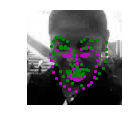

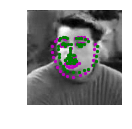

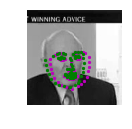

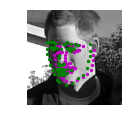

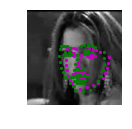

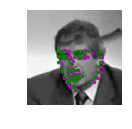

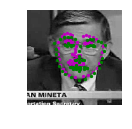

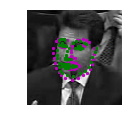

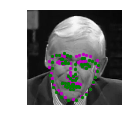

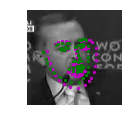

In [22]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

# visualize_output(test_images, test_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [23]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I chose Adam Optimizer because according to the research, Adam optimizer works very well in most of the tasks, and also the research on facial keypoints showed that Adam Optimizer works well on facial keypoint, and it appeared giving me better results than SGD optimizer .
and the loss function that I chose was Smooth L1 loss because this function giving me better result than any other loss function.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Initially I took a large network that was taking too much time and too much load on cpu, so I removed multiple layers and simplified it, next time while training network architecture had very few layers and was very inaccurate, so again I looked up at architecture and to avoid overfitting, used dropout layer.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Initially I decided less epochs with reasonable time training, and then after training I did some hunches and end with the loss of 0.002 thats seems.
and batch-size for this length of data set is as small as possible, not that much but yeah average, here as well I tried with many batch sizes and ended up with 20.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.1395577  -0.00723492  0.04736193  0.13281643 -0.15047194]
 [-0.1145615  -0.01007199  0.21341531 -0.00685887 -0.18142688]
 [-0.15899034  0.04131707  0.04873598  0.21893868 -0.09427095]
 [-0.1898281  -0.12314077  0.14282759  0.20364732 -0.12897418]
 [-0.22677583  0.03485983  0.17669533  0.17251854 -0.05593453]]
(5, 5)


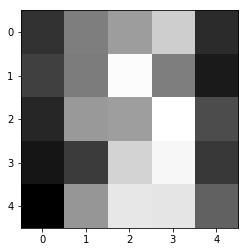

In [60]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

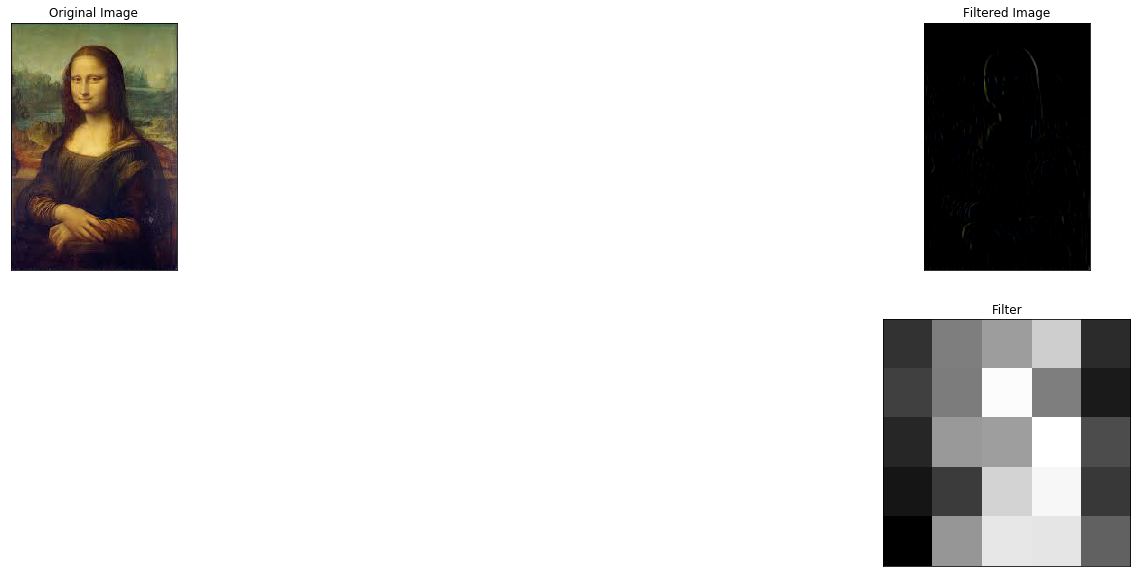

In [65]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

# Loading the image
img = cv2.imread('images/mona_lisa.jpg')

#convert colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Applying the filter to image
filtered = cv2.filter2D(img, -1, w[filter_index][0])

# Visualize the effects and the corresponding filter
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(222, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Filtered Image")

ax = fig.add_subplot(224, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')
ax.set_title("Filter")

ax = fig.add_subplot(221, xticks = [], yticks = [])
ax.imshow(img)
ax.set_title("Original Image")

plt.show()

# Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The Indexed Feature 1 is an edge detection filter, defines outline of the object and can be seen from the filtered image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!